<a href="https://colab.research.google.com/github/zseebrz/colab/blob/main/Day_1_Practice_Task_ResNet_for_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Data, Big Insights workshop

## Cosine Loss Practice notebook
LAB Day 1

Created by Miklos Toth

Co-Authors are: Levente Szabados and Gergo Szabo

Sources
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [practice on CIFAR10 with Keras](https://github.com/jerett/Keras-CIFAR10) (some code snippets copied from here)

# 0. Preparation: Mount Google Drive, for saving our results


In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
data_tmp_dir='./drive/My Drive/_training_tmp1/'
if not os.path.exists(data_tmp_dir):
    os.mkdir(data_tmp_dir)
    print("datadir created")
else:
    print("datadir exists")

Mounted at /content/drive
datadir created


#### Checking GPU Info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 23 15:10:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import time

print("Tensorflow version:",tf.__version__)
SEED=100
tf.random.set_seed(SEED)

Tensorflow version: 2.3.0


## 1. Prepare dataset

We are going to use CIFAR10 and CIFAR100 datasets

https://www.cs.toronto.edu/~kriz/cifar.html 

In [4]:


dataset, info = tfds.load('cifar10', as_supervised = True, with_info = True, batch_size =-1)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteI9FJAH/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteI9FJAH/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



#### Let's Limit the number of samples
We are in the small data era, lets simulate this by  taking only a subset of the samples. 

In [6]:
N_CLASSES=10
TRAIN_SAMPLE_LIMIT=N_CLASSES*100


In [7]:

train_x = dataset_train[0][0:TRAIN_SAMPLE_LIMIT] / 255
train_y = dataset_train[1][0:TRAIN_SAMPLE_LIMIT]


test_x = dataset_test[0] / 255
test_y = dataset_test[1]
       

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(1000, 32, 32, 3)
(1000,)
(10000, 32, 32, 3)
(10000,)


(array([122.,  82.,  94., 102.,  92., 102.,  83., 112., 110., 101.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

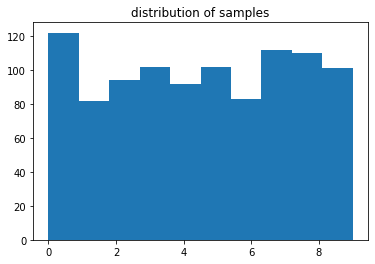

In [8]:
plt.title("distribution of samples")
plt.hist(train_y.numpy(),bins=N_CLASSES)

## 2. Data Augmentation

source of the data augmentation is: https://github.com/shoji9x9/CIFAR-10-By-small-ResNet/ 

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, cutout_mask_size = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cutout_mask_size = cutout_mask_size
        self.seed_numbers=range(10000)
        self.seed_counter=0
        
    def cutout(self, x, y):
        return np.array(list(map(self._cutout, x))), y
    
    def _cutout(self, image_origin):
        
        image = np.copy(image_origin)
        mask_value = image.mean()

        h, w, _ = image.shape
        if self.seed_counter>=10000-2:
            self.seed_counter=0
        np.random.seed(self.seed_counter)
        self.seed_counter+=1
        top = np.random.randint(0 - self.cutout_mask_size // 2, h - self.cutout_mask_size)
        np.random.seed(self.seed_counter)
        self.seed_counter+=1
        left = np.random.randint(0 - self.cutout_mask_size // 2, w - self.cutout_mask_size)
        bottom = top + self.cutout_mask_size
        right = left + self.cutout_mask_size

        
        if top < 0:
            top = 0
        if left < 0:
            left = 0

        
        image[top:bottom, left:right, :].fill(mask_value)
        return image
    
    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)
        
        
        while True:
            batch_x, batch_y = next(batches)
            
            if self.cutout_mask_size > 0:
                result = self.cutout(batch_x, batch_y)
                batch_x, batch_y = result                        
                
            yield (batch_x, batch_y)     

datagen_parameters = {"horizontal_flip": True, "width_shift_range": 0.1, "height_shift_range": 0.1, "cutout_mask_size": 16}
datagen = CustomImageDataGenerator(**datagen_parameters)
datagen_for_test = ImageDataGenerator()


## 3. Define model

In [10]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add, Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize

#### Using Resnet20 Architecture
For resnet, see https://arxiv.org/pdf/1512.03385.pdf 
<br> You can also look at section 4.2, on the full dataset they reached 90%+ accuracy with different architectures. Please note in this notebook we will not reach anything close since we have radically changed the dataset to simulate small data environment.


In [11]:


def identity_block(inp, filters, kernel_size, block, layer):   
    conv_name = 'id_conv_b' + block + '_l' + layer
    batch_name = 'id_batch_b' + block + '_l' + layer
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name + '_a')(inp)
    x = BatchNormalization(name=batch_name + '_a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name + '_b')(x)
    x = BatchNormalization(name=batch_name + '_b')(x)
    
    add = Add()([inp, x])
    x = Activation('relu')(add)
    return x

def convolutional_block(inp, filters, kernel_size, block, layer, strides=2):
    conv_name = 'res_conv_b' + block + '_l' + layer
    batch_name = 'res_batch_b' + block + '_l' + layer
    
    y = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', strides=strides, kernel_initializer='he_normal', name=conv_name + '_a')(inp)
    y = BatchNormalization(name=batch_name + '_a')(y)
    y = Activation('relu')(y)
    
    y = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name + '_b')(y)
    y = BatchNormalization(name=batch_name + '_b')(y)
    
    shortcut = Conv2D(filters=filters, kernel_size=1, strides=strides, kernel_initializer='he_normal', name=conv_name + '_shortcut')(inp)
    shortcut = BatchNormalization(name=batch_name + '_shortcut')(shortcut)
    
    add = Add()([shortcut, y])
    y = Activation('relu')(add)
    
    return y

def resnet(last_layer):
    inp = Input(shape=(32, 32, 3), name='input')

    conv1 = Conv2D(16, 3, strides=1, padding='same', name='conv1')(inp)
    #conv1 = BatchNormalization(name='batch2')(conv1)
    conv1 = Activation('relu')(conv1)

    conv2 = identity_block(conv1, 16, 3, '2', '2')
    conv2 = identity_block(conv2, 16, 3, '2', '3')
    conv2 = identity_block(conv2, 16, 3, '2', '4')

    conv3 = convolutional_block(conv2, 32, 3, '3', '1')
    conv3 = identity_block(conv3, 32, 3, '3', '2')
    conv3 = identity_block(conv3, 32, 3, '3', '3')

    conv4 = convolutional_block(conv3, 64, 3, '4', '1')
    conv4 = identity_block(conv4, 64, 3, '4', '2')
    conv4 = identity_block(conv4, 64, 3, '4', '3')

    avg_pool = GlobalAveragePooling2D()(conv4)

    out = last_layer(avg_pool)
    model = Model(inp, out)
    return model

# This is just an example for using the function above, we wont use this model:
model = resnet(last_layer=Dense(1))

In [12]:
from io import StringIO
import re
def print_model(model):
    with StringIO() as buf:
        model.summary(print_fn=lambda x: buf.write(x + "\n"))
        summary = buf.getvalue()
    print(summary)
    re1 = re.match(r"(.|\s)*Total params: ", summary)
    re2 = re.match(r"(.|\s)*Total params: [\d|,]+", summary)
    total_params = summary[re1.end():re2.end()]
print_model(model)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
id_conv_b2_l2_a (Conv2D)        (None, 32, 32, 16)   2320        activation[0][0]                 
_______________________________________________________________________________________

## 4. Prepare and Train a Baseline model using softmax with crossentropy

Lets use the simple Adam optimizer, with the same learning rate throughout the entire notebook. 

In [13]:
from tensorflow.keras.optimizers import Adam, SGD
lr = 0.001
optimizer = Adam(learning_rate=lr)


In [22]:
# TASK: Create the model and compile it. Use softmax with crossentropy
# Be careful with the last layer's activation function.
# What should be the activation function for the last layer in case of cross entropy? And what is the format of the labels?
# How many neurons do you need at the last layer?

my_last_layer= Dense(N_CLASSES, activation='softmax') ### PUT YOUR CODE HERE ###
model = resnet(last_layer=my_last_layer)
my_loss = 'sparse_categorical_crossentropy' ### PUT YOUR CODE HERE ### 
model.compile(optimizer=optimizer, loss= my_loss, metrics=["accuracy"])


## 5. Train 

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
num_epoch = 100
batch_size = 100

number_train = TRAIN_SAMPLE_LIMIT # without limit it should be info.splits["train"].num_examples
number_test = info.splits["test"].num_examples
number_train

1000

In [24]:
checkpoint = ModelCheckpoint(filepath = data_tmp_dir+"ResNet-for-CIFAR10-with-Keras-crossentropy.h5",
                             monitor="val_loss", verbose=1, save_best_only=True)

history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size,seed=SEED), 
                    epochs=num_epoch, 
                    steps_per_epoch=number_train//batch_size, 
                    validation_data=datagen_for_test.flow(test_x, test_y, batch_size=batch_size,seed=SEED), 
                    validation_steps=number_test//batch_size,
                    verbose=2,
                    callbacks=[checkpoint])



Epoch 1/100

Epoch 00001: val_loss improved from inf to 4.36139, saving model to ./drive/My Drive/_training_tmp1/ResNet-for-CIFAR10-with-Keras-crossentropy.h5
10/10 - 2s - loss: 2.4871 - accuracy: 0.1330 - val_loss: 4.3614 - val_accuracy: 0.0900
Epoch 2/100

Epoch 00002: val_loss improved from 4.36139 to 4.31859, saving model to ./drive/My Drive/_training_tmp1/ResNet-for-CIFAR10-with-Keras-crossentropy.h5
10/10 - 1s - loss: 2.0636 - accuracy: 0.2340 - val_loss: 4.3186 - val_accuracy: 0.1000
Epoch 3/100

Epoch 00003: val_loss improved from 4.31859 to 3.18640, saving model to ./drive/My Drive/_training_tmp1/ResNet-for-CIFAR10-with-Keras-crossentropy.h5
10/10 - 1s - loss: 1.9277 - accuracy: 0.2830 - val_loss: 3.1864 - val_accuracy: 0.0983
Epoch 4/100

Epoch 00004: val_loss did not improve from 3.18640
10/10 - 1s - loss: 1.8424 - accuracy: 0.3310 - val_loss: 3.4514 - val_accuracy: 0.1017
Epoch 5/100

Epoch 00005: val_loss improved from 3.18640 to 3.15751, saving model to ./drive/My Drive/_

Normally results are above 90% for accuracy with the full data set and SGD and Resnet 50. Since we used limited data, we have less accuracy.



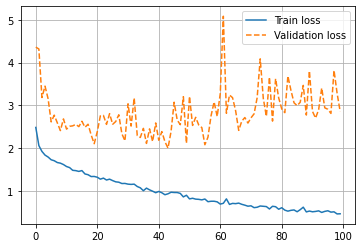

In [25]:
def plot_loss(history,ylim_values=None):
    plt.plot(history.history["loss"], label = 'Train loss')
    plt.plot(history.history["val_loss"], linestyle = 'dashed', label = 'Validation loss')
    if ylim_values is not None:
        plt.ylim(ylim_values)
    plt.grid()
    plt.legend()
    plt.show()

plot_loss(history)

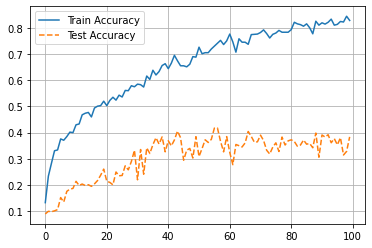

In [26]:

def plot_accuracy(history):

  plt.plot(history.history["accuracy"], label = 'Train Accuracy')
  plt.plot(history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
  plt.grid()
  plt.legend()
  plt.show()
plot_accuracy(history)

Saving Results

In [27]:
path_softmax=data_tmp_dir+"cifar10_"+str(TRAIN_SAMPLE_LIMIT)+"_softmax_"+str(num_epoch)+"_epoch_resnet20.pkl"
df_history=pd.DataFrame(history.history)
df_history.to_csv(path_softmax)

### Cosine Loss

Lets implement a cosine loss with tf.keras. This paper describes different loss functions: https://arxiv.org/pdf/1901.09054.pdf

Hints: 
* You could use the one hot encoder here: https://www.tensorflow.org/api_docs/python/tf/one_hot
* You could use the built in CosineSimilarity https://www.tensorflow.org/api_docs/python/tf/keras/losses/CosineSimilarity 

In [33]:
#TASK: create the cosine loss function. 
def my_cosine_similarity():
    def loss(y_true, y_pred):
        target_one_hot = tf.one_hot(y_true, depth=N_CLASSES, on_value=1.0) ### PUT YOUR CODE HERE ### ,depth=### PUT YOUR CODE HERE ### ,on_value= ### PUT YOUR CODE HERE ### )
        target_one_hot = target_one_hot[:,0,:]

        cosine_loss = tf.keras.losses.CosineSimilarity(axis=1) ### PUT YOUR CODE HERE ### Dont forget axis!!!
        return 1+cosine_loss(target_one_hot, y_pred)

    return loss


In [37]:
# TASK: Create the model and compile it. Be careful with the last layer's activation function.
# What should be the activation function for the last layer in case of cosine loss? 
model = resnet(last_layer = Dense(N_CLASSES, activation='linear'))

# TASK: use the above defined function.
model.compile(optimizer=optimizer, loss=my_cosine_similarity(), metrics=["accuracy"])

In [38]:

history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size,seed=SEED), 
                    epochs=num_epoch, 
                    steps_per_epoch=number_train//batch_size, 
                    validation_data=datagen_for_test.flow(test_x, test_y, batch_size=batch_size,seed=SEED), 
                    validation_steps=number_test//batch_size,
                    verbose=2)


Epoch 1/100
10/10 - 2s - loss: 0.7884 - accuracy: 0.1470 - val_loss: 1.0859 - val_accuracy: 0.1000
Epoch 2/100
10/10 - 1s - loss: 0.6246 - accuracy: 0.2060 - val_loss: 0.8698 - val_accuracy: 0.1193
Epoch 3/100
10/10 - 1s - loss: 0.6042 - accuracy: 0.2430 - val_loss: 0.8200 - val_accuracy: 0.0988
Epoch 4/100
10/10 - 1s - loss: 0.5935 - accuracy: 0.2680 - val_loss: 0.8418 - val_accuracy: 0.0986
Epoch 5/100
10/10 - 1s - loss: 0.5826 - accuracy: 0.2720 - val_loss: 0.8204 - val_accuracy: 0.1065
Epoch 6/100
10/10 - 1s - loss: 0.5757 - accuracy: 0.2860 - val_loss: 0.7745 - val_accuracy: 0.1277
Epoch 7/100
10/10 - 1s - loss: 0.5629 - accuracy: 0.3080 - val_loss: 0.7833 - val_accuracy: 0.1969
Epoch 8/100
10/10 - 1s - loss: 0.5560 - accuracy: 0.3120 - val_loss: 0.7272 - val_accuracy: 0.2396
Epoch 9/100
10/10 - 1s - loss: 0.5421 - accuracy: 0.3340 - val_loss: 0.7570 - val_accuracy: 0.2107
Epoch 10/100
10/10 - 1s - loss: 0.5402 - accuracy: 0.3550 - val_loss: 0.8056 - val_accuracy: 0.1909
Epoch 11/

In [ ]:
plot_loss(history)

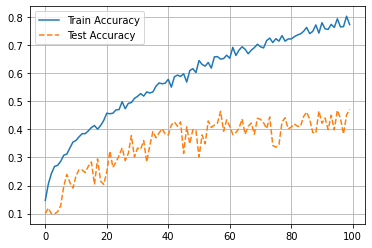

In [39]:
plot_accuracy(history)

In [40]:

path_my_cosine_similarity=data_tmp_dir+"cifar10_"+str(TRAIN_SAMPLE_LIMIT)+"_sample_my_cosine_similarity_"+str(num_epoch)+"_epoch_resnet20.pkl"
df_history=pd.DataFrame(history.history)
df_history.to_csv(path_my_cosine_similarity)

### Cosine + Crossentropy loss
According to this paper: https://arxiv.org/pdf/1901.09054.pdf

You can reach even better performance if you use Cosine Loss and Crossentropy together.

Hints: 
* You could use the one hot encoder here: https://www.tensorflow.org/api_docs/python/tf/one_hot
* You could use the built in CosineSimilarity https://www.tensorflow.org/api_docs/python/tf/keras/losses/CosineSimilarity 
* You could use the Crossentropy function https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


In [51]:
#TASK implement the cosine_crossentropy loss function. 
def my_cosine_crossentropy():
    def loss(y_true, y_pred):
        #first one hot encoding for the labels
        target_one_hot = tf.one_hot(y_true, depth=10, on_value=1.0) ### PUT YOUR CODE HERE ### ,depth=### PUT YOUR CODE HERE ### ,on_value=### PUT YOUR CODE HERE ### )
        target_one_hot = target_one_hot[:,0,:]
        
        #use the CosineSimilarity class from above
        cosine_loss = tf.keras.losses.CosineSimilarity(axis=1) ### PUT YOUR CODE HERE ### 
        cosine_loss_tensor=1+cosine_loss(target_one_hot, y_pred)
        
        #Watch out for the crossentropy, is it sparse or not sparse?
        cce = tf.keras.losses.CategoricalCrossentropy() ### PUT YOUR CODE HERE ### 
        cce_loss=cce(target_one_hot, tf.nn.softmax(y_pred))
        
        #Take multiplication of them. (or you may try add them up)
        cosine_loss_plus_cce_loss= cosine_loss_tensor*cce_loss ### PUT YOUR CODE HERE ### 
        return cosine_loss_plus_cce_loss

    return loss

In [52]:
# TASK: Create the model and compile it. Be careful with the last layer's activation function.
# What should be the activation function for the last layer in case of cosine loss? 
model = resnet(last_layer=Dense(10, activation='linear'))
# TASK: use the above defined function.
model.compile(optimizer=optimizer, loss=my_cosine_crossentropy(), metrics=["accuracy"])

In [53]:

history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size,seed=SEED), 
                    epochs=num_epoch, 
                    steps_per_epoch=number_train//batch_size, 
                    validation_data=datagen_for_test.flow(test_x, test_y, batch_size=batch_size,seed=SEED), 
                    validation_steps=number_test//batch_size,
                    verbose=2)


Epoch 1/100
10/10 - 2s - loss: 2.1480 - accuracy: 0.1750 - val_loss: 18.0199 - val_accuracy: 0.1000
Epoch 2/100
10/10 - 1s - loss: 1.2663 - accuracy: 0.2530 - val_loss: 83.2432 - val_accuracy: 0.1000
Epoch 3/100
10/10 - 1s - loss: 1.1705 - accuracy: 0.2530 - val_loss: 58.3403 - val_accuracy: 0.1000
Epoch 4/100
10/10 - 1s - loss: 1.0360 - accuracy: 0.3460 - val_loss: 28.0804 - val_accuracy: 0.1000
Epoch 5/100
10/10 - 1s - loss: 0.9894 - accuracy: 0.3650 - val_loss: 14.5011 - val_accuracy: 0.1000
Epoch 6/100
10/10 - 1s - loss: 0.9210 - accuracy: 0.3780 - val_loss: 4.4762 - val_accuracy: 0.1633
Epoch 7/100
10/10 - 1s - loss: 0.9151 - accuracy: 0.3610 - val_loss: 3.9874 - val_accuracy: 0.1465
Epoch 8/100
10/10 - 1s - loss: 0.8236 - accuracy: 0.4240 - val_loss: 3.3428 - val_accuracy: 0.1882
Epoch 9/100
10/10 - 1s - loss: 0.8342 - accuracy: 0.4430 - val_loss: 2.7028 - val_accuracy: 0.1940
Epoch 10/100
10/10 - 1s - loss: 0.8289 - accuracy: 0.4190 - val_loss: 2.7784 - val_accuracy: 0.1744
Epoc

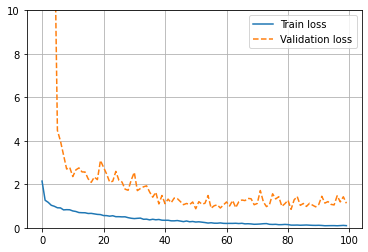

In [54]:
plot_loss(history,ylim_values=[0,10])

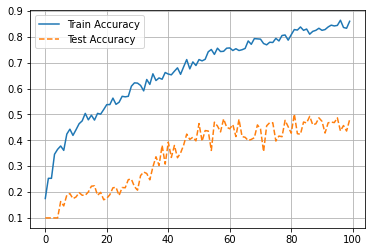

In [55]:
plot_accuracy(history)

In [56]:

path_my_cosine_crossentropy=data_tmp_dir+"cifar10_"+str(TRAIN_SAMPLE_LIMIT)+"_sample_my_cosine_crossentropy_"+str(num_epoch)+"_epoch_resnet20.pkl"

df_history=pd.DataFrame(history.history)
df_history.to_csv(path_my_cosine_crossentropy)

### Compare all results

In [57]:

softmax_df_history=pd.read_csv(path_softmax)
my_cosine_crossentropy_df_history=pd.read_csv(path_my_cosine_crossentropy)
my_cosine_similarity_df_history=pd.read_csv(path_my_cosine_similarity)

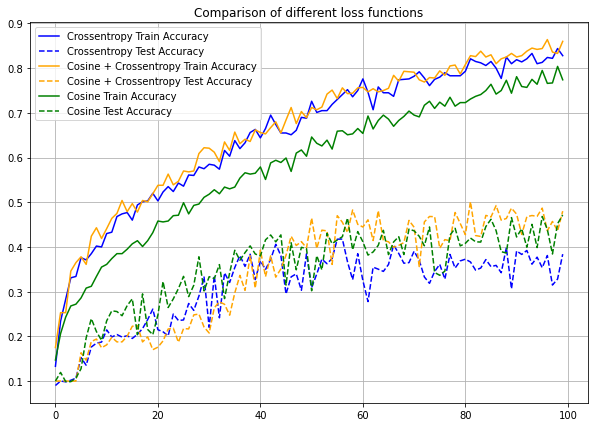

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(softmax_df_history["accuracy"], label = 'Crossentropy Train Accuracy',color="blue")
plt.plot(softmax_df_history["val_accuracy"], linestyle = 'dashed',color="blue", label = 'Crossentropy Test Accuracy')
plt.plot(my_cosine_crossentropy_df_history["accuracy"], label = 'Cosine + Crossentropy Train Accuracy',color="orange")
plt.plot(my_cosine_crossentropy_df_history["val_accuracy"], linestyle = 'dashed', label = 'Cosine + Crossentropy Test Accuracy',color="orange")
plt.plot(my_cosine_similarity_df_history["accuracy"],color="green", label = 'Cosine Train Accuracy')
plt.plot(my_cosine_similarity_df_history["val_accuracy"],color="green", linestyle = 'dashed', label = 'Cosine Test Accuracy')
plt.grid()
plt.title("Comparison of different loss functions")
plt.legend()
plt.show()

In [59]:
diff_pct_cosine_softmax=(my_cosine_similarity_df_history["val_accuracy"]-softmax_df_history["val_accuracy"]).mean()*100
print("On average cosine loss is better then crossentropy with {:.2f} %".format(diff_pct_cosine_softmax))
diff_pct_cosine_softmax=(my_cosine_crossentropy_df_history["val_accuracy"]-softmax_df_history["val_accuracy"]).mean()*100
print("On average cosine loss is better then crossentropy with {:.2f} %".format(diff_pct_cosine_softmax))

On average cosine loss is better then crossentropy with 4.39 %
On average cosine loss is better then crossentropy with 3.67 %
